In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/network-anamoly-detection/Test.txt
/kaggle/input/network-anamoly-detection/Train.txt
/kaggle/input/network-anamoly-detection/Network Anamoly Detection.docx


In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import time
import multiprocessing

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from collections import Counter
from sklearn.preprocessing import LabelEncoder, StandardScaler

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.metrics import confusion_matrix, r2_score, mean_squared_error
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report, precision_recall_curve
import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv("/kaggle/input/network-anamoly-detection/Train.txt",sep=",",names=["duration","protocoltype","service","flag","srcbytes","dstbytes","land", "wrongfragment","urgent","hot","numfailedlogins","loggedin", "numcompromised","rootshell","suattempted","numroot","numfilecreations", "numshells","numaccessfiles","numoutboundcmds","ishostlogin",
"isguestlogin","count","srvcount","serrorrate", "srvserrorrate",
"rerrorrate","srvrerrorrate","samesrvrate", "diffsrvrate", "srvdiffhostrate","dsthostcount","dsthostsrvcount","dsthostsamesrvrate", "dsthostdiffsrvrate","dsthostsamesrcportrate",
"dsthostsrvdiffhostrate","dsthostserrorrate","dsthostsrvserrorrate",
"dsthostrerrorrate","dsthostsrvrerrorrate","attack", "lastflag"])
df.head()

,duration,protocoltype,service,flag,srcbytes,dstbytes,land,wrongfragment,urgent,hot,...,dsthostsamesrvrate,dsthostdiffsrvrate,dsthostsamesrcportrate,dsthostsrvdiffhostrate,dsthostserrorrate,dsthostsrvserrorrate,dsthostrerrorrate,dsthostsrvrerrorrate,attack,lastflag
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19
3,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
4,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21


In [4]:
df.shape

(125973, 43)

In [5]:
df.describe()

,duration,srcbytes,dstbytes,land,wrongfragment,urgent,hot,numfailedlogins,loggedin,numcompromised,...,dsthostsrvcount,dsthostsamesrvrate,dsthostdiffsrvrate,dsthostsamesrcportrate,dsthostsrvdiffhostrate,dsthostserrorrate,dsthostsrvserrorrate,dsthostrerrorrate,dsthostsrvrerrorrate,lastflag
count,125973.00000,1.259730e+05,1.259730e+05,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,...,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000
mean,287.14465,4.556674e+04,1.977911e+04,0.000198,0.022687,0.000111,0.204409,0.001222,0.395736,0.279250,...,115.653005,0.521242,0.082951,0.148379,0.032542,0.284452,0.278485,0.118832,0.120240,19.504060
std,2604.51531,5.870331e+06,4.021269e+06,0.014086,0.253530,0.014366,2.149968,0.045239,0.489010,23.942042,...,110.702741,0.448949,0.188922,0.308997,0.112564,0.444784,0.445669,0.306557,0.319459,2.291503
min,0.00000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.00000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,10.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.000000
50%,0.00000,4.400000e+01,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,63.000000,0.510000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000
75%,0.00000,2.760000e+02,5.160000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,255.000000,1.000000,0.070000,0.060000,0.020000,1.000000,1.000000,0.000000,0.000000,21.000000
max,42908.00000,1.379964e+09,1.309937e+09,1.000000,3.000000,3.000000,77.000000,5.000000,1.000000,7479.000000,...,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,21.000000


As we can see 'land', 'urgent', 'numfailedlogins', 'numoutboundcmds' have mostly zero values so we can drop these columns.

In [6]:
df.drop(['land','urgent','numfailedlogins','numoutboundcmds'],axis=1,inplace=True)

In [7]:
df.isna().sum()

duration                  0
protocoltype              0
service                   0
flag                      0
srcbytes                  0
dstbytes                  0
wrongfragment             0
hot                       0
loggedin                  0
numcompromised            0
rootshell                 0
suattempted               0
numroot                   0
numfilecreations          0
numshells                 0
numaccessfiles            0
ishostlogin               0
isguestlogin              0
count                     0
srvcount                  0
serrorrate                0
srvserrorrate             0
rerrorrate                0
srvrerrorrate             0
samesrvrate               0
diffsrvrate               0
srvdiffhostrate           0
dsthostcount              0
dsthostsrvcount           0
dsthostsamesrvrate        0
dsthostdiffsrvrate        0
dsthostsamesrcportrate    0
dsthostsrvdiffhostrate    0
dsthostserrorrate         0
dsthostsrvserrorrate      0
dsthostrerrorrate   

In [8]:
df.select_dtypes(exclude=[np.number])

,protocoltype,service,flag,attack
0,tcp,ftp_data,SF,normal
1,udp,other,SF,normal
2,tcp,private,S0,neptune
3,tcp,http,SF,normal
4,tcp,http,SF,normal
...,...,...,...,...
125968,tcp,private,S0,neptune
125969,udp,private,SF,normal
125970,tcp,smtp,SF,normal
125971,tcp,klogin,S0,neptune


As we are focussing on Binomial Classification for this dataset, we can make all other classes other than normal as 'attack'

In [9]:
df['attack'].loc[df['attack']!='normal']='attack'

In [10]:
le=LabelEncoder()

In [11]:
df['protocoltype']=le.fit_transform(df['protocoltype'])
df['service']=le.fit_transform(df['service'])
df['flag']=le.fit_transform(df['flag'])
df['attack']=le.fit_transform(df['attack'])

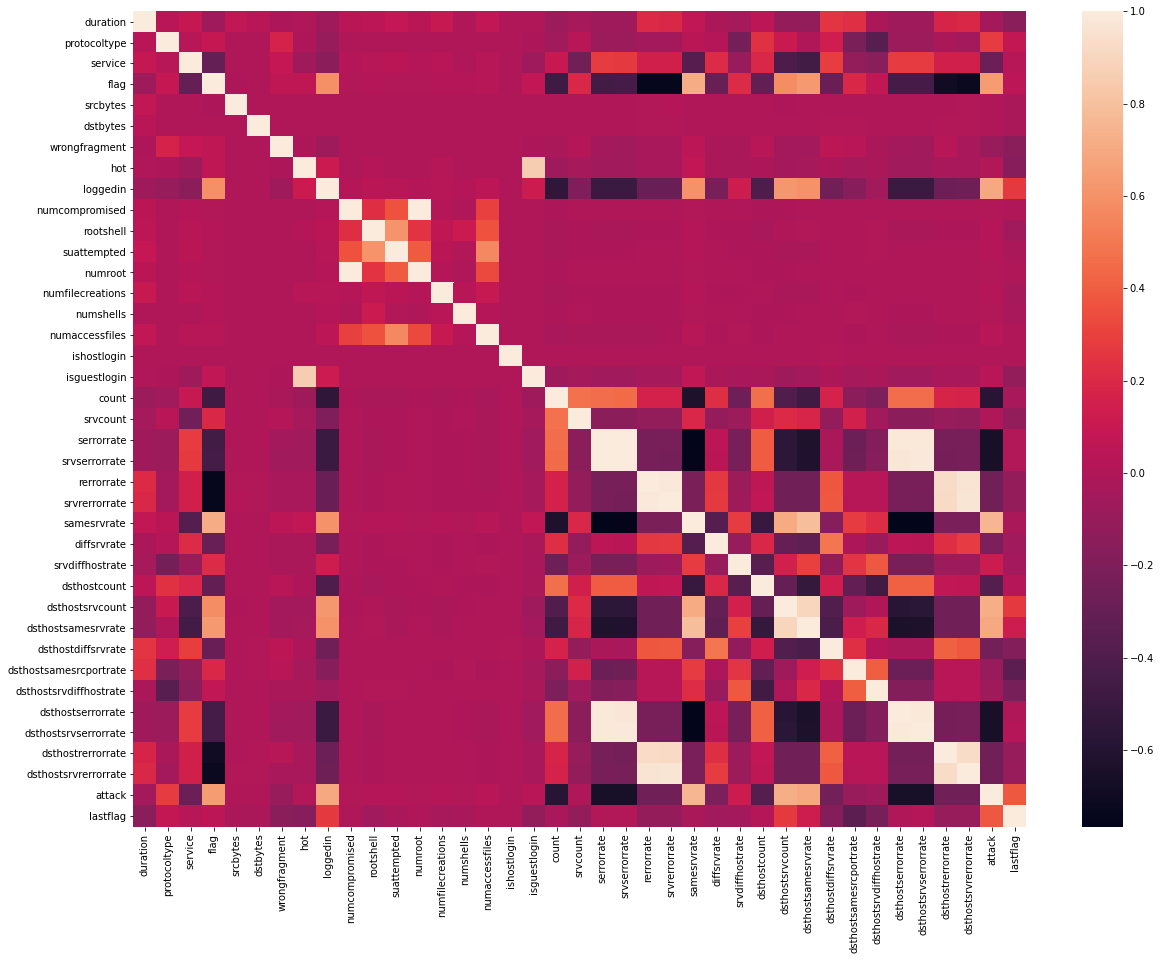

In [12]:
plt.figure(figsize=(20,15))
sns.heatmap(df.corr())

In [13]:
X=df.drop(['attack'],axis=1)
y=df['attack']

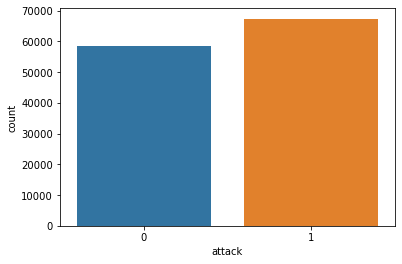

In [14]:
sns.countplot(df['attack'])

In [15]:
print("Class distribution: {}".format(Counter(y)))

Class distribution: Counter({1: 67343, 0: 58630})


In [16]:
scaler = StandardScaler()
scaler.fit(X)
X_transformed = scaler.transform(X)

**Using Logistic Regression**

In [17]:
lr=LogisticRegression()
lr.fit(X_transformed,y)
lr_pred=lr.predict(X_transformed)

In [18]:
lr_df=pd.DataFrame()
lr_df['actual']=y
lr_df['pred']=lr_pred

In [19]:
lr_df.head()

,actual,pred
0,1,1
1,1,0
2,0,0
3,1,1
4,1,1


In [20]:
print(accuracy_score(y, lr_pred))

0.9783207512720979


In [21]:
confusion_matrix(y, lr_pred)

array([[57558,  1072],
       [ 1659, 65684]])

In [22]:
print(classification_report(y, lr_pred))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98     58630
           1       0.98      0.98      0.98     67343

    accuracy                           0.98    125973
   macro avg       0.98      0.98      0.98    125973
weighted avg       0.98      0.98      0.98    125973



**Using Random Forest Classifier**

In [23]:
rf=RandomForestClassifier()
rf.fit(X_transformed,y)
rf_pred=rf.predict(X_transformed)

In [24]:
rf_df=pd.DataFrame()
rf_df['actual']=y
rf_df['pred']=rf_pred
rf_df.head()

,actual,pred
0,1,1
1,1,1
2,0,0
3,1,1
4,1,1


In [25]:
print(accuracy_score(y, rf_pred))

1.0


In [26]:
confusion_matrix(y, rf_pred)

array([[58630,     0],
       [    0, 67343]])

In [27]:
print(classification_report(y, rf_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     58630
           1       1.00      1.00      1.00     67343

    accuracy                           1.00    125973
   macro avg       1.00      1.00      1.00    125973
weighted avg       1.00      1.00      1.00    125973



**We can see Random Forest Classifier is giving better accuracy in comparison to Logistic Regression.**

Using Random Forest Classifier Model on test data:

In [28]:
test_df = pd.read_csv("/kaggle/input/network-anamoly-detection/Test.txt",sep=",",names=["duration","protocoltype","service","flag","srcbytes","dstbytes","land", "wrongfragment","urgent","hot","numfailedlogins","loggedin", "numcompromised","rootshell","suattempted","numroot","numfilecreations", "numshells","numaccessfiles","numoutboundcmds","ishostlogin",
"isguestlogin","count","srvcount","serrorrate", "srvserrorrate",
"rerrorrate","srvrerrorrate","samesrvrate", "diffsrvrate", "srvdiffhostrate","dsthostcount","dsthostsrvcount","dsthostsamesrvrate", "dsthostdiffsrvrate","dsthostsamesrcportrate",
"dsthostsrvdiffhostrate","dsthostserrorrate","dsthostsrvserrorrate",
"dsthostrerrorrate","dsthostsrvrerrorrate","attack", "lastflag"])
test_df.head()

,duration,protocoltype,service,flag,srcbytes,dstbytes,land,wrongfragment,urgent,hot,...,dsthostsamesrvrate,dsthostdiffsrvrate,dsthostsamesrcportrate,dsthostsrvdiffhostrate,dsthostserrorrate,dsthostsrvserrorrate,dsthostrerrorrate,dsthostsrvrerrorrate,attack,lastflag
0,0,tcp,private,REJ,0,0,0,0,0,0,...,0.04,0.06,0.00,0.00,0.0,0.0,1.00,1.00,neptune,21
1,0,tcp,private,REJ,0,0,0,0,0,0,...,0.00,0.06,0.00,0.00,0.0,0.0,1.00,1.00,neptune,21
2,2,tcp,ftp_data,SF,12983,0,0,0,0,0,...,0.61,0.04,0.61,0.02,0.0,0.0,0.00,0.00,normal,21
3,0,icmp,eco_i,SF,20,0,0,0,0,0,...,1.00,0.00,1.00,0.28,0.0,0.0,0.00,0.00,saint,15
4,1,tcp,telnet,RSTO,0,15,0,0,0,0,...,0.31,0.17,0.03,0.02,0.0,0.0,0.83,0.71,mscan,11


In [29]:
test_df.select_dtypes(exclude=[np.number])

,protocoltype,service,flag,attack
0,tcp,private,REJ,neptune
1,tcp,private,REJ,neptune
2,tcp,ftp_data,SF,normal
3,icmp,eco_i,SF,saint
4,tcp,telnet,RSTO,mscan
...,...,...,...,...
22539,tcp,smtp,SF,normal
22540,tcp,http,SF,normal
22541,tcp,http,SF,back
22542,udp,domain_u,SF,normal


In [30]:
test_df['attack'].loc[test_df['attack']!='normal']='attack'

In [31]:
test_df['protocoltype']=le.fit_transform(test_df['protocoltype'])
test_df['service']=le.fit_transform(test_df['service'])
test_df['flag']=le.fit_transform(test_df['flag'])
test_df['attack']=le.fit_transform(test_df['attack'])

In [32]:
test_df.drop(['land','urgent','numfailedlogins','numoutboundcmds'],axis=1,inplace=True)

In [33]:
X_test=test_df.drop(['attack'],axis=1)
y_test=test_df['attack']

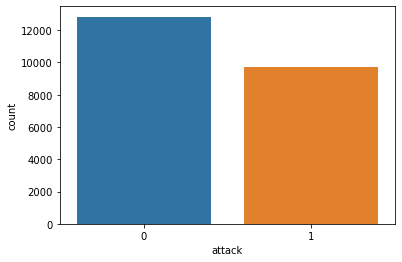

In [34]:
sns.countplot(test_df['attack'])

In [35]:
X_test_transformed = scaler.transform(X_test)

In [36]:
test_pred=rf.predict(X_test_transformed)

In [37]:
rf_test_df=pd.DataFrame()
rf_test_df['actual']=y_test
rf_test_df['pred']=test_pred

In [38]:
rf_test_df.head()

,actual,pred
0,0,0
1,0,0
2,1,1
3,0,0
4,0,0


In [39]:
print(accuracy_score(y_test, test_pred))

0.8176454932576295


In [40]:
target_names=["attack","normal"]

In [41]:
print(classification_report(y_test, test_pred,target_names=target_names))

              precision    recall  f1-score   support

      attack       0.97      0.70      0.81     12833
      normal       0.71      0.97      0.82      9711

    accuracy                           0.82     22544
   macro avg       0.84      0.84      0.82     22544
weighted avg       0.86      0.82      0.82     22544



In [42]:
confusion_matrix(y_test, test_pred)

array([[8986, 3847],
       [ 264, 9447]])

In [43]:
tn, fp, fn, tp = confusion_matrix(y_test, test_pred).ravel()

In [44]:
print("True Negatives:",tn)
print("False Positives:",fp)
print("False Negatives:",fn)
print("True Positives:",tp)

True Negatives: 8986
False Positives: 3847
False Negatives: 264
True Positives: 9447
